# Test out VAEs

In [14]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import json
from PIL import Image

import torch
# from torch import nn
# from torch.autograd import Variable
from torchvision import transforms


# Nicer way to import the module?
sys.path.append(str(Path.cwd().parent))

from utils.display import read_img_to_np, torch_to_np
from utils.norms import shape_norm, MNIST_norm, shape_grid_norm
import model.model as module_arch
import data_loader.data_loaders as module_data
device = torch.device("cuda:0")


# from utils.loading import load_net
# from utils.data import make_generators_DF
# from utils.train_val import validate_epoch
# from utils.evaluation import evaluate_adv_files_df, get_metrics
# import json

# print(device)
# print(torch.cuda.device_count())
# print(torch.cuda.current_device())

# MODEL_PATH = PATH /'models' / 'cvae'

In [84]:
# path to dir where all training results saved
def get_model_loaders_config(PATH):
    PATH = Path(PATH)
    config_loc = PATH / 'config.json'
    weight_path = PATH / 'model_best.pth'
    config = json.load(open(config_loc))
    
    def get_instance(module, name, config, *args):
        return getattr(module, config[name]['type'])(*args, **config[name]['args'])

    data_loader = get_instance(module_data, 'data_loader', config)['train']
    valid_data_loader = get_instance(module_data, 'data_loader', config)['val']
    model = get_instance(module_arch, 'arch', config)
    checkpoint = torch.load(weight_path)
    state_dict = checkpoint['state_dict']
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)

    model.load_state_dict(state_dict)
    model = model.to(device).eval()
    
    return model, data_loader, valid_data_loader, config


def display_results_auto(vae_model, config, norm, device, num_samples=5, data='bw', size = 32, label_col_name='label', save_loc=None):
    with torch.cuda.device(device.index): # ??? Why the fuck???
        files_dict_loc = config['data_loader']['args']['files_dict_loc']
        with open(files_dict_loc, 'rb') as f:
            files_df = pickle.load(f)['train']
            
        if label_col_name:
            all_labels = files_df[label_col_name].unique()
        else:
            all_labels = list(range(num_samples))
        row_names = []
        col_names = ['Original', "Reconstructed"]

        fig, ax = plt.subplots(num_samples, 2, sharex='col', sharey='row',figsize=(10,10))

        for i, label in enumerate(all_labels[0:num_samples]):
            if label_col_name:
                sample_df = files_df.loc[files_df[label_col_name] == label].sample(n=1)
                label = sample_df[label_col_name].iloc[0]
                row_names.append(label)
            else:
                sample_df = files_df.sample(n=1)
            img_path = sample_df['path'].iloc[0]

            if data == 'bw': # MNIST
                img = read_img_to_np(img_path, bw=True)
                transform = transforms.Compose([
                                                transforms.Resize(size),
                                                transforms.ToTensor(),
                                                transforms.Normalize(*norm)])
            else:
                img = read_img_to_np(img_path, bw=False, size=size)
                transform = transforms.Compose([
                                                transforms.Resize(size),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.4914, 0.4822, 0.4465], 
                                                                     [0.2023, 0.1994, 0.2010])])

            tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)

            tensor_label = torch.from_numpy(np.array(label)).unsqueeze(0).type(torch.LongTensor).to(device)

            output = model(tensor_img,  deterministic=False)
            recon_x = output[0]
            
            ax[i, 0].imshow(img, cmap='Greys',  interpolation='nearest')
            ax[i, 1].imshow(torch_to_np(recon_x), cmap='Greys',  interpolation='nearest')
            ax[i, 0].axis('off')
            ax[i, 1].axis('off')

        for curr_ax, col in zip(ax[0], col_names):
            curr_ax.set_title(col)
        if label_col_name:
            for curr_ax, row in zip(ax[:,0], row_names):
                curr_ax.set_ylabel(row, rotation=0, size='large')
        if save_loc:
            plt.savefig(save_loc, bbox_inches='tight')    

### MNIST - Check standard autoencoder

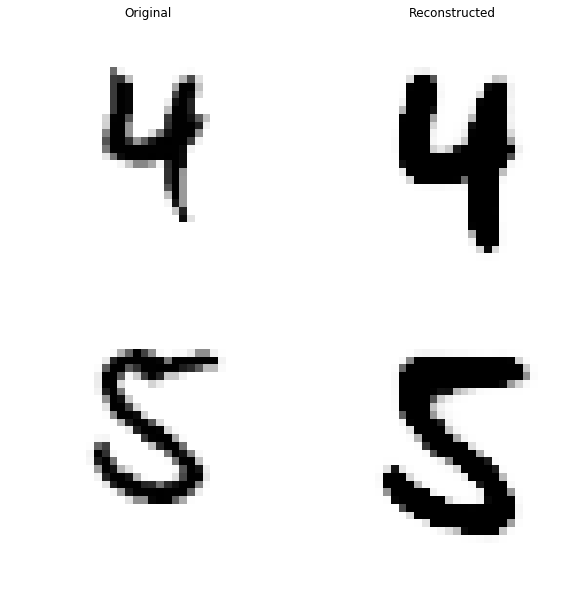

In [96]:
PATH = '/media/rene/data/hvae/mnist/vae_001_mnist/1214_153603'
model, data_loader, valid_data_loader, config = get_model_loaders_config(PATH)
loc = "/media/rene/code/hvae/imgs/VAE_mnist.png"  
display_results_auto(model, config, MNIST_norm, device, num_samples=2, label_col_name='class', save_loc=loc)

## Shapes

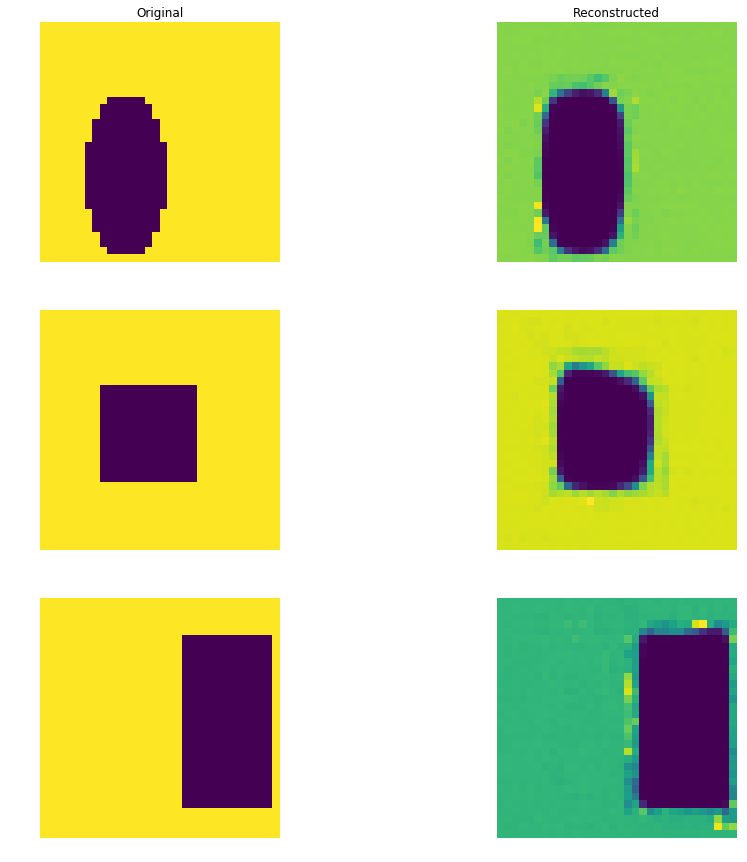

In [6]:
PATH = '/media/rene/data/hvae/shapes_output/vae_001_rand_size_loc/1215_033032'
model, data_loader, valid_data_loader, config = get_model_loaders_config(PATH)
display_results_auto(model, config, shape_norm, device, num_samples=3, label_col_name='shape_type')

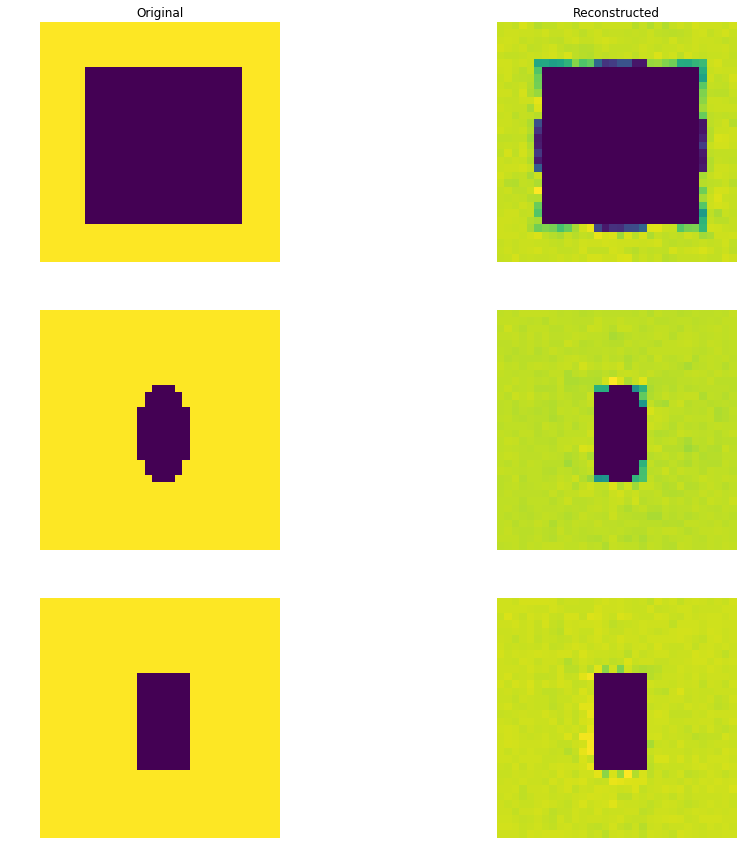

In [49]:
PATH = '/media/rene/data/hvae/shapes_output/vae_abs_001_rand_size/1215_210912/'

model, data_loader, valid_data_loader, config = get_model_loaders_config(PATH)
display_results_auto(model, config, shape_norm, device, num_samples=3, label_col_name='shape_type')

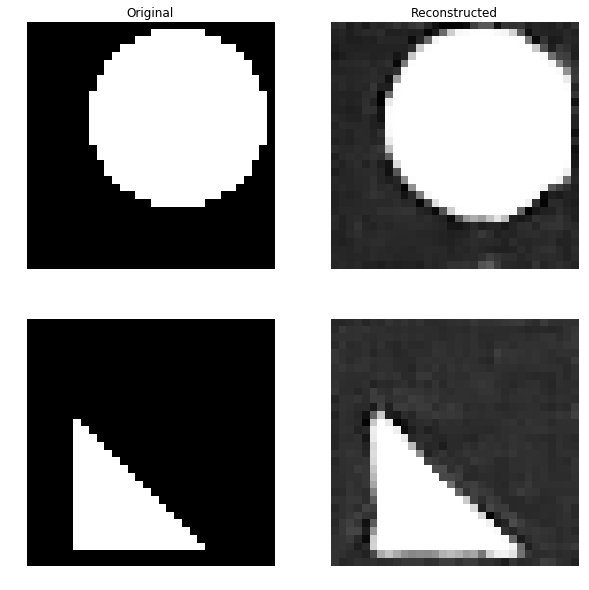

In [92]:
PATH = '/media/rene/data/hvae/shapes_output/vae_abs_001_rand_size_loc/1215_182441/'

model, data_loader, valid_data_loader, config = get_model_loaders_config(PATH)
loc = "/media/rene/code/hvae/imgs/VAE_single.png"  
display_results_auto(model, config, shape_norm, device, num_samples=2, label_col_name=None, save_loc=loc)

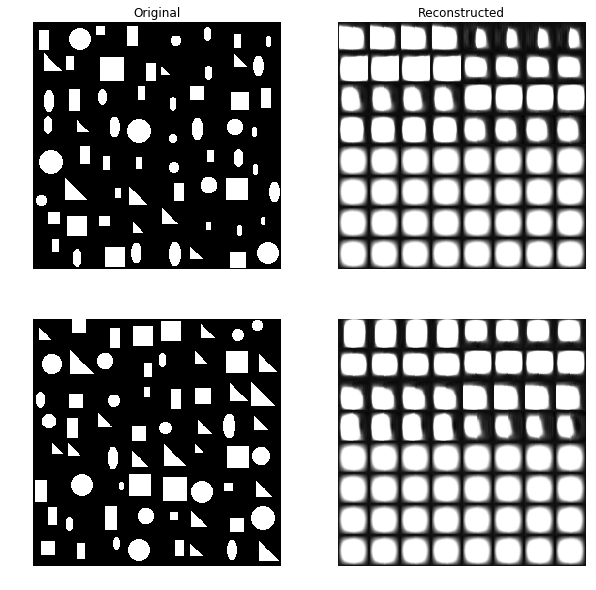

In [97]:
PATH = '/media/rene/data/hvae/shapes_output/NotHVAE_L32_L32_rand_size_loc_g8/1215_143606'
model, data_loader, valid_data_loader, config = get_model_loaders_config(PATH)
model = model.eval()
loc = "/media/rene/code/hvae/imgs/NotHVAE_grid.png"
display_results_auto(model, config, shape_grid_norm, device, num_samples=2, size = 256, label_col_name=None, save_loc=loc)

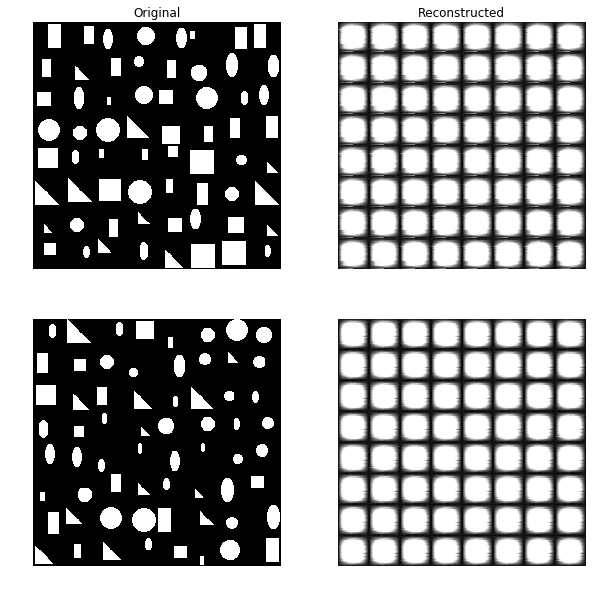

In [98]:
PATH = '/media/rene/data/hvae/shapes_output/HVAE_L32_L32_rand_size_loc_g8/1215_213203'
model, data_loader, valid_data_loader, config = get_model_loaders_config(PATH)
model = model.eval()
loc = "/media/rene/code/hvae/imgs/HVAE_grid.png"
display_results_auto(model, config, shape_grid_norm, device, num_samples=2, size = 256, label_col_name=None, save_loc=loc)

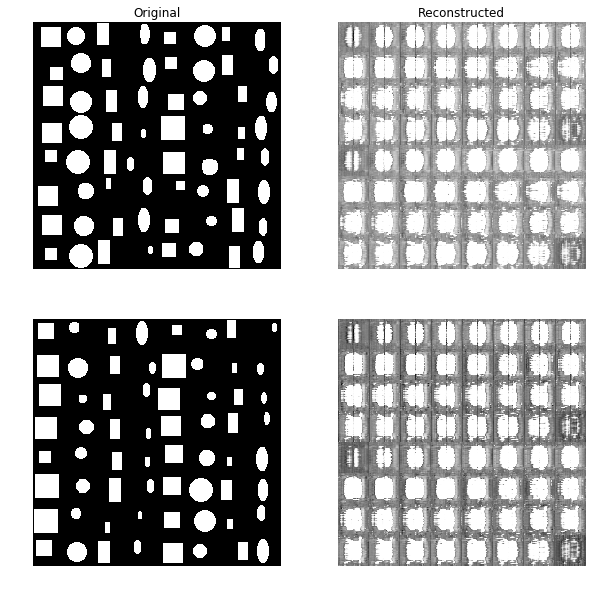

In [100]:
PATH = '/media/rene/data/hvae/shapes_output/HVAE_pre_L64_L32_rand_size_loc_g8_struc/1216_120840'
model, data_loader, valid_data_loader, config = get_model_loaders_config(PATH)
model = model.eval()
loc = "/media/rene/code/hvae/imgs/HVAE_grid_struc.png"
display_results_auto(model, config, shape_grid_norm, device, num_samples=2, size = 256, label_col_name=None, save_loc=loc)

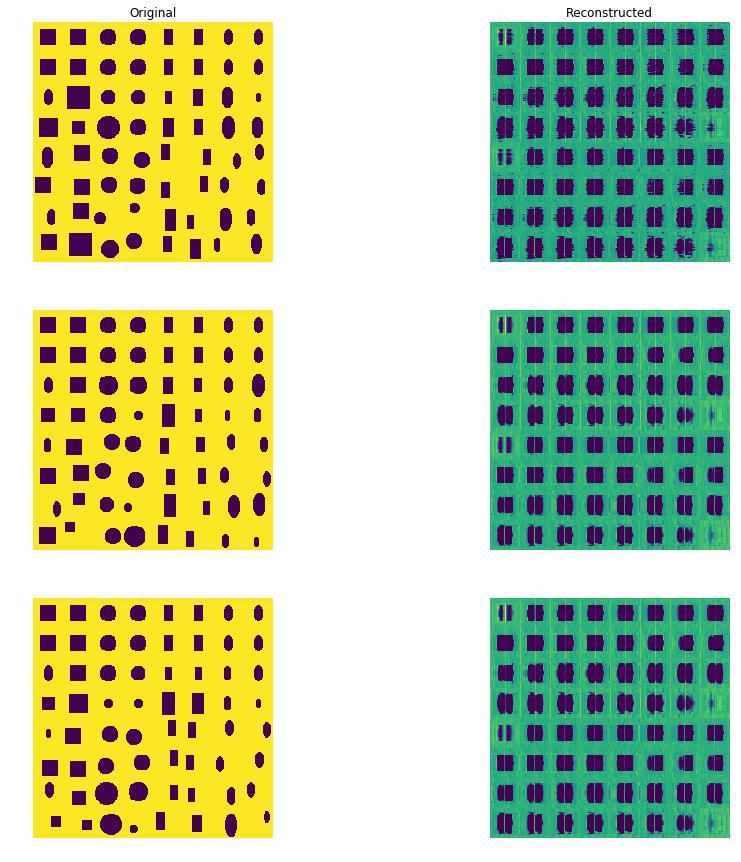

In [46]:
PATH = '/media/rene/data/hvae/shapes_output/HVAE_pre_L64_L32_rand_size_loc_g8_struc2/1216_164138'
model, data_loader, valid_data_loader, config = get_model_loaders_config(PATH)
model = model.eval()
display_results_auto(model, config, shape_grid_norm, device, num_samples=2, size = 256, label_col_name=None)

In [ ]:
PATH = '/media/rene/data/hvae/shapes_output/HVAE_pre_L64_L32_rand_size_loc_g8_struc2_final/1217_001406'
model, data_loader, valid_data_loader, config = get_model_loaders_config(PATH)
model = model.eval()
loc = "/media/rene/code/hvae/imgs/HVAE_grid_struc2_final.png"
display_results_auto(model, config, shape_grid_norm, device, num_samples=2, size = 256, label_col_name=None, save_loc=loc)

# Local Latent layer Sampling

In [ ]:
PATH = '/media/rene/data/hvae/shapes_output/HVAE_pre_L64_L32_rand_size_loc_g8_struc2_final/1217_001406'
model, data_loader, valid_data_loader, config = get_model_loaders_config(PATH)
model = model.eval()
loc = "/media/rene/code/hvae/imgs/HVAE_grid_struc2_final.png"   
display_results_auto(model, config, shape_grid_norm, device, num_samples=2, size = 256, label_col_name=None, save_loc=loc)